In [4]:
%matplotlib inline

import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from torch.utils.data import DataLoader
import torch
from typing import List, Literal
from pathlib import Path
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, fbeta_score
import re

from predpy.dataset import MultiTimeSeriesDataset
from predpy.experimentator import (
    DatasetParams, ModelParams,
    Experimentator, load_experimentator, load_last_experimentator)
from predpy.plotter import plot_anomalies, get_ids_ranges, get_cls_ids_ranges
from anomaly_detection import (
    AnomalyDetector, fit_run_detection, exp_fit_run_detection,
    get_dataset, get_train_test_ds, get_dataset_names, load_anom_scores,
    MovingStdAD
)

from notebook_utils.modeling import (
    predict, get_a_scores, get_rec_fbeta_score_conf_mat,
    get_a_scores_one_per_point, get_recon_one_per_point,
    adjust_point_cls_with_window,
    th_ws_experiment, stats_experiment,
    calculate_rec_wdd, recalculate_wdd
)
from notebook_utils.plotting import (
    plot_scores, plot_kde, plot_dataset, plot_scores_and_bands
)
from notebook_utils.save_load import (
    save_th_exp, load_th_exp
)
from notebook_utils.ts_stats import (
    get_bollinger, get_std, get_diff
)
from string import Template


os.chdir('/home/stachu/Projects/Anomaly_detection/TSAD')
sns.set_style()

# Choosing best models scores
Selection is made based on reconstruction error score.

In [8]:
models_1_1_info = {
    'ConvAE_ws200_nk20_ks5_es50': '2022-06-15_17:51:55',
    'LSTMAE_h100_z50_l2': '2022-06-15_05:11:43',
    'TadGAN_h50_l1_z10': '2022-06-15_17:51:55',
    'VELC_h100_l2_z50_N50_th0.0': '2022-06-15_05:11:43',
    'AnomTrans_l2_d128_lambda3': '2022-06-16_01:36:24',
}
models_2_1_info = {
    'ConvAE_ws200_nk20_ks5_es50': '2022-06-15_17:51:55',
    'LSTMAE_h50_z10_l1': '2022-06-14_23:58:28',
    'TadGAN_h50_l1_z10': '2022-06-15_17:51:55',
    'VELC_h100_l2_z50_N50_th0.025': '2022-06-15_17:51:55',
    'AnomTrans_l3_d512_lambda10': '2022-06-14_23:58:28',
}
models_3_10_info = {
    'ConvAE_ws200_nk20_ks5_es50': '2022-06-15_17:51:55',
    'LSTMAE_h50_z10_l1': '2022-06-14_23:58:28',
    'TadGAN_h50_l1_z10': '2022-06-15_17:51:55',
    'VELC_h100_l2_z50_N50_th0.025': '2022-06-15_17:51:55',
    'AnomTrans_l2_d128_lambda3': '2022-06-15_21:37:27',
}

In [19]:
path =\
    Template('data/Industry/ServerMachineDataset/test_label/machine-$m_id.csv')
m_1_1_point_cls = pd.read_csv(
    path.substitute(m_id='1-1'), header=None)\
    .iloc[:, 0].to_numpy()
m_2_1_point_cls = pd.read_csv(
    path.substitute(m_id='2-1'), header=None)\
    .iloc[:, 0].to_numpy()
m_3_10_point_cls = pd.read_csv(
    path.substitute(m_id='3-10'), header=None)\
    .iloc[:, 0].to_numpy()

In [15]:
scores_dirpath_temp = Template('notebook_a_scores/ServerMachineDataset/$ds_name/$m_name/$exp_date/')

def load_np_scores(models_info: dict, ds_name: str, test: bool = True):
    scores = {
        'ConvAE': None, 'LSTMAE': None, 'TadGAN': None,
        'VELC': None, 'AnomTrans': None}
    if test:
        file_name = 'test_a_scores.npy'
    else:
        file_name = 'train_a_scores.npy'
    for m_name, exp_date in models_info.items():
        path = scores_dirpath_temp.substitute(
            ds_name=ds_name, m_name=m_name, exp_date=exp_date)
        model_cls_name = m_name.split('_')[0]
        scores[model_cls_name] = np.load(
            path + file_name, allow_pickle=True)
    return scores

# Plotting scores

In [17]:
m_2_1_scores = load_np_scores(models_2_1_info, 'machine-2-1')

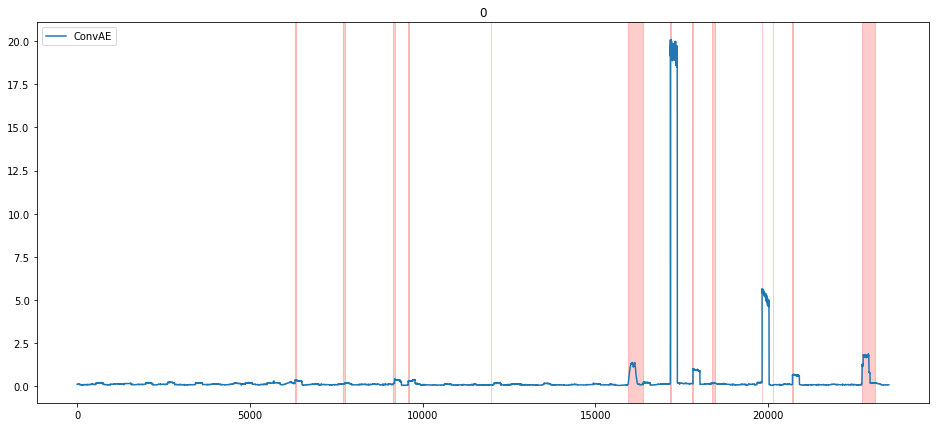

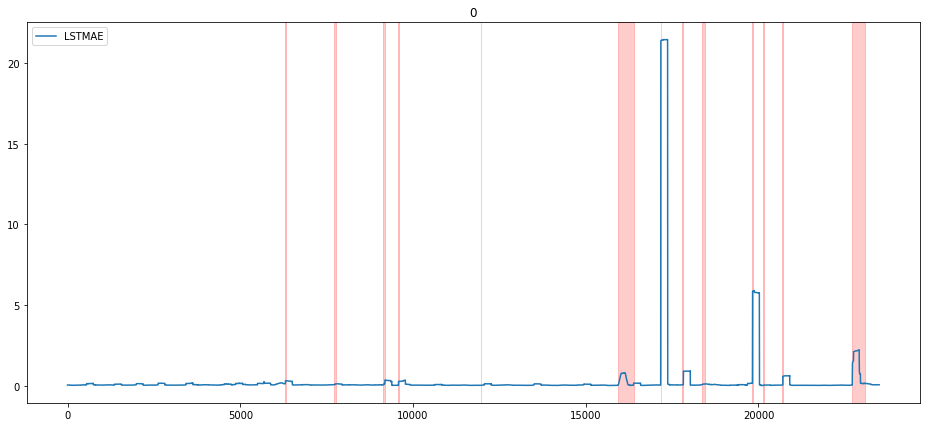

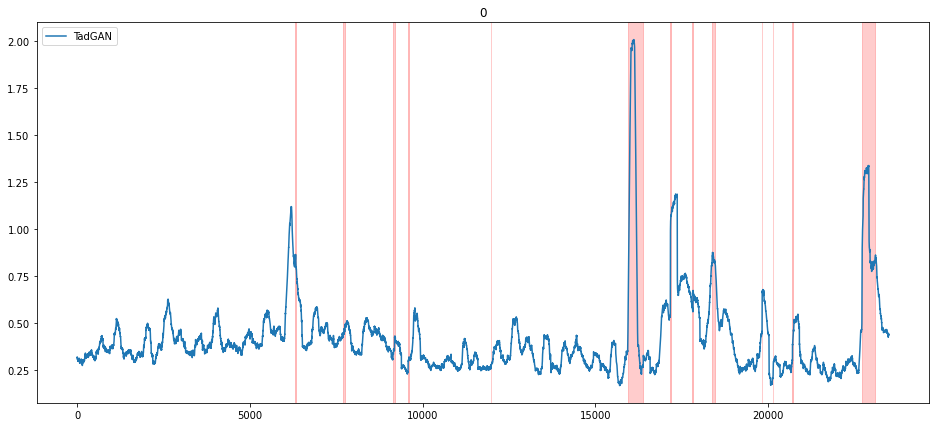

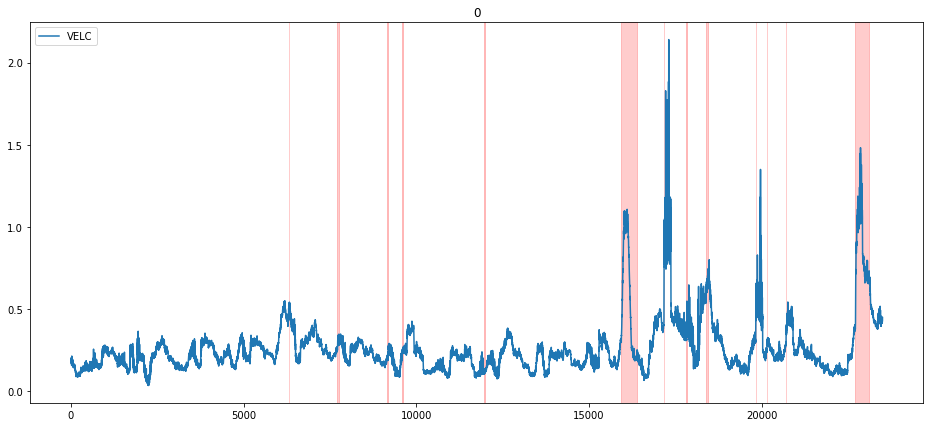

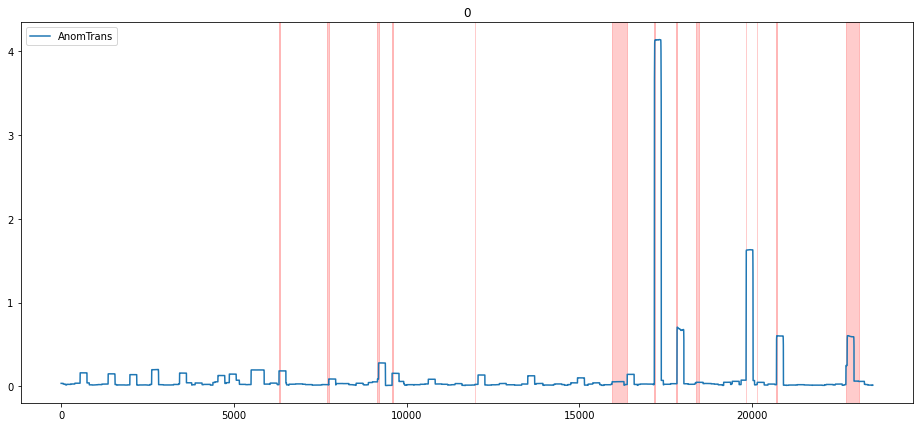

In [24]:
anom_ranges = get_cls_ids_ranges(
    pd.Index(range(len(m_2_1_point_cls))), m_2_1_point_cls, shift=-199)
for m_cls in m_2_1_scores:
    plot_dataset(
        {m_cls: m_2_1_scores[m_cls]}, anoms_vrects=anom_ranges, figsize=(16, 7));